In [ ]:
%pwd 

In [1]:
# %cd /home/ubu-admin/Developer/tensorflow-wavelets
%cd /workspaces/OpenDVCW
from train import TrainOpenDVCW
import numpy as np
import load
import OpenDVCW
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import flow_vis
import DataGen
import time
import datetime
import cv2
import flyingchairs_data_loader
import helpers
import flow_utils
from IPython.display import clear_output

/workspaces/OpenDVCW


2023-01-04 18:49:23.073535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext tensorboard

In [3]:
BATCH_SIZE = 16
EPOCHS = 40
HEIGHT = 240
WIDTH = 240
CHANNLES = 3
M=256
lr_init = 1e-5
I_QP=27
wavelet_name = "haar"
figsize = (20, 20)
template = 'Epoch {}, Loss Wavelet: {}, Accuracy Wavelet: {}, Loss DVC: {}, Accuracy DVC: {}'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir_w = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/train_w'
train_log_dir = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/train'
train_w_summary_writer = tf.summary.create_file_writer(train_log_dir_w)
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

val_log_dir_w = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/val_w'
val_log_dir = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/val'
val_w_summary_writer = tf.summary.create_file_writer(val_log_dir_w)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

FLAGS = helpers.FlyingChairsFlags(batch_size=BATCH_SIZE)
data_gen = flyingchairs_data_loader.DataLoader(FLAGS.data_dir, "/workspaces/OpenDVCW/development/fc_smaill_train.txt", FLAGS.val_list)
train_dataset, val_dataset = data_gen.create_tf_dataset(FLAGS)


2023-01-04 18:49:24.610678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 18:49:24.612488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 18:49:24.612589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 18:49:24.613354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
print(len(train_dataset), len(val_dataset))

62 41


In [5]:
inputs1 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
inputs2 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
loss_w, output_w = OpenDVCW.WaveletsOpticalFlow(BATCH_SIZE, HEIGHT, WIDTH, wavelet_name)([inputs1, inputs2])
loss, output = OpenDVCW.OpticalFlow(BATCH_SIZE, HEIGHT, WIDTH)([inputs1, inputs2])

model_w = tf.keras.Model([inputs1, inputs2], [loss_w, output_w])
model = tf.keras.Model([inputs1, inputs2], [loss, output])

In [6]:
model_w.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 wavelets_optical_flow (Wavelet  ((),                240050      ['input_1[0][0]',                
 sOpticalFlow)                   (None, 240, 240, 2               'input_2[0][0]']            

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 optical_flow (OpticalFlow)     ((),                 240050      ['input_1[0][0]',                
                                 (None, 240, 240, 2               'input_2[0][0]']          

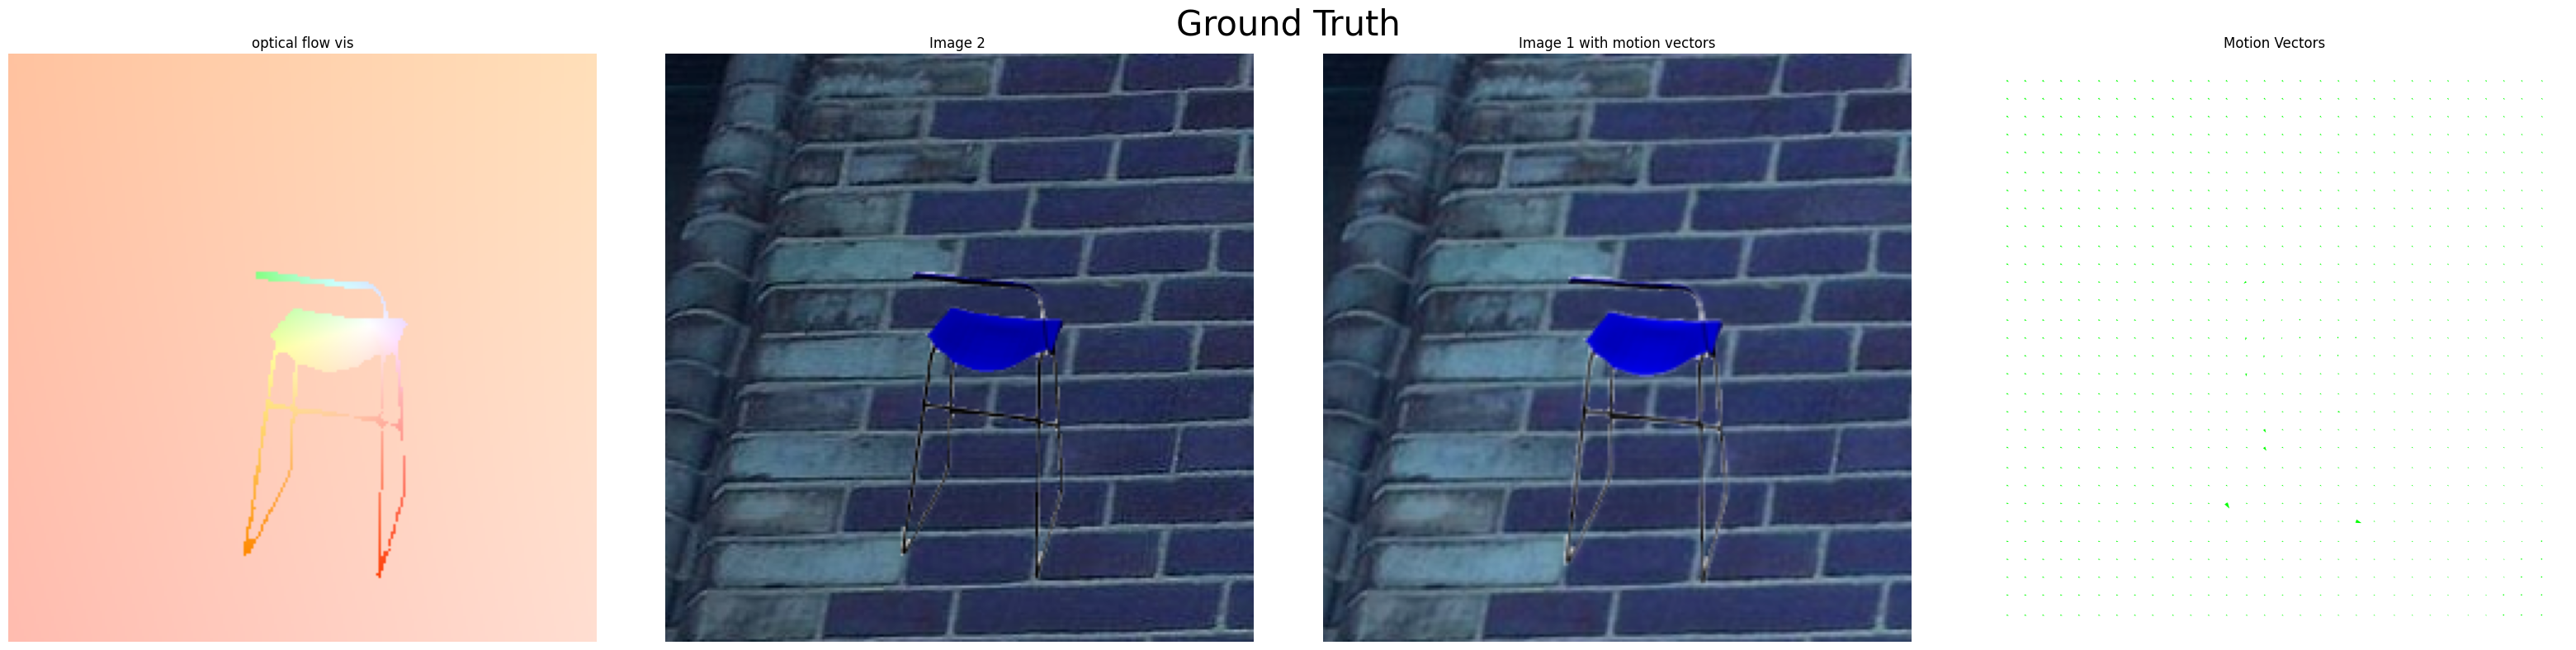

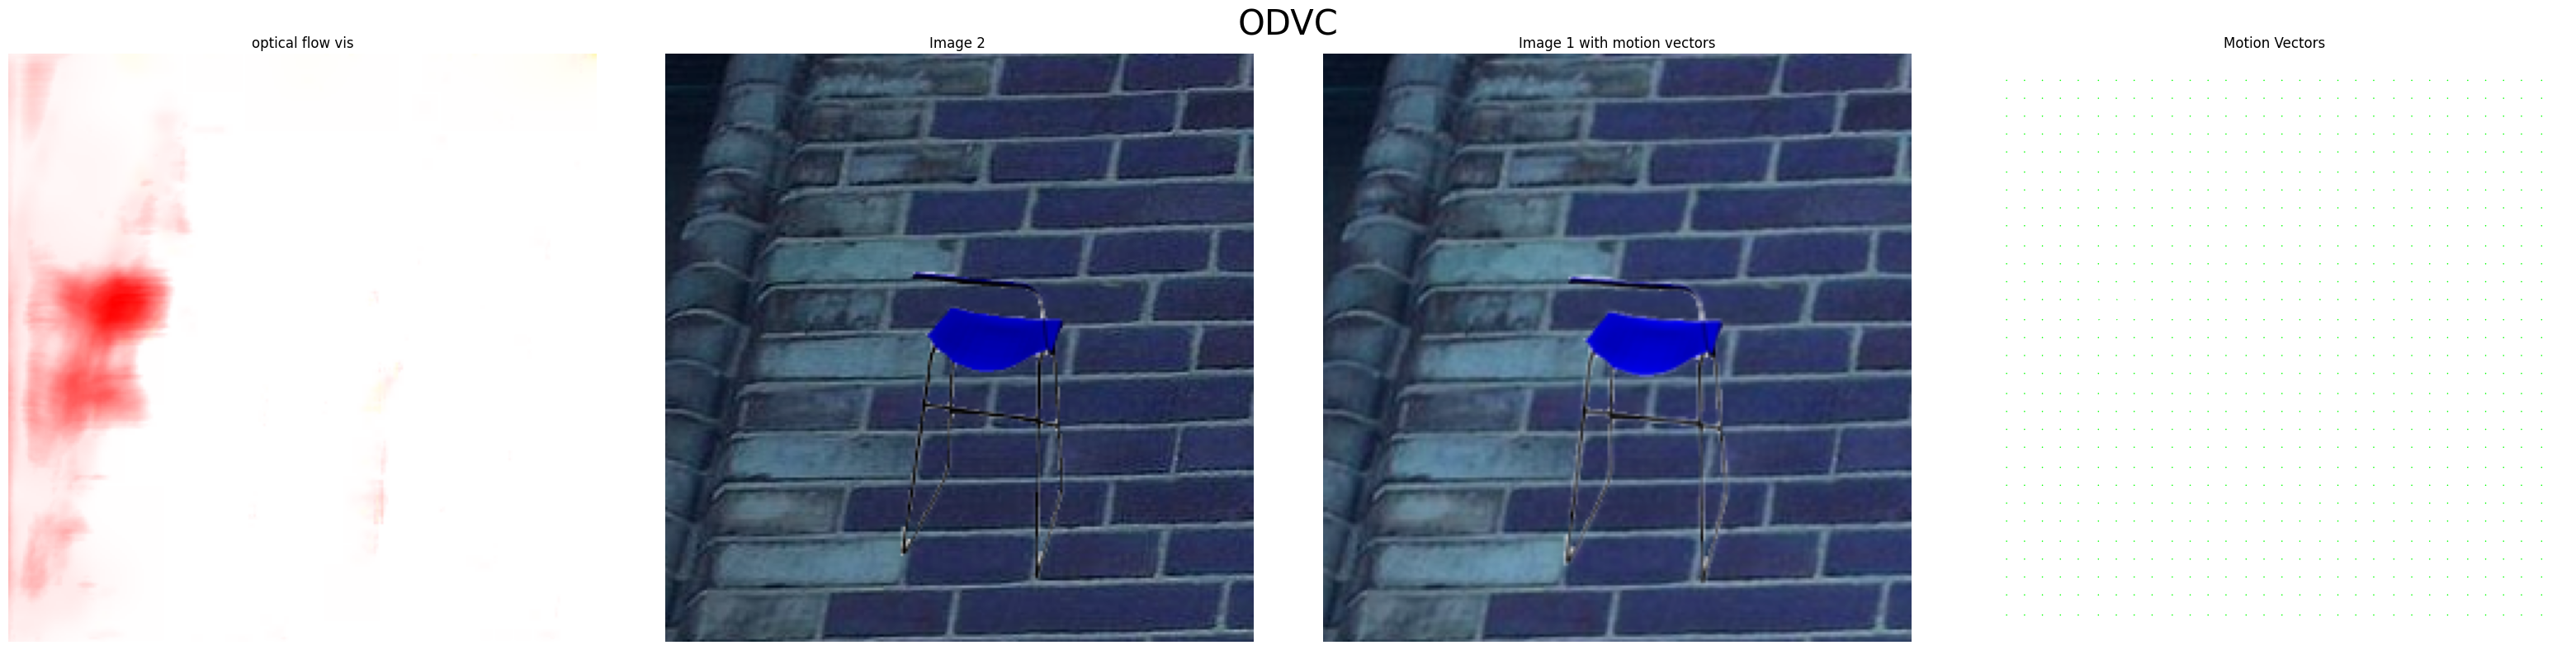

992/992 [==============================] - 13s 13ms/step - train_loss: 7.2297


In [10]:
metrics_names = ['train_loss','train_loss_w', 'train_mse', 'train_mse_w'] 
val_metrics_names = ["val_loss", "val_loss_w"]
train_loss = tf.keras.metrics.Mean(metrics_names[0], dtype=tf.float32)
train_loss_w = tf.keras.metrics.Mean(metrics_names[1], dtype=tf.float32)

val_loss = tf.keras.metrics.Mean("val_loss", dtype=tf.float32)
val_loss_w = tf.keras.metrics.Mean("val_loss_w", dtype=tf.float32)

# Instantiate an optimizer.
optimizer_w = tf.keras.optimizers.Adam(learning_rate=lr_init)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_init)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_init, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0005)

num_of_training_samples = len(train_dataset)*BATCH_SIZE #+ len(val_dataset)*BATCH_SIZE

loss_f = tf.keras.losses.MeanAbsoluteError()

# Iterate over the batches of a dataset.
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1, EPOCHS))
    
    progBar = tf.keras.utils.Progbar(num_of_training_samples, stateful_metrics=metrics_names)
    cnt = 0
    for im_pairs, gt_flow in train_dataset:
        im1 = im_pairs[:, :, :, :3]
        im2 = im_pairs[:, :, :, 3:]
        
        
        im1 = tf.cast(im1, dtype=tf.float32)
        im2 = tf.cast(im2, dtype=tf.float32)
        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            loss_value, logits = model([im1, im2], training=True)
            # # Loss value for this batch.
            # Get gradients of loss wrt the weights.
            loss_value_n = loss_f(-gt_flow, logits)
        gradients = tape.gradient(loss_value_n, model.trainable_weights)
        
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_loss(loss_value_n)
        
        
        # with tf.GradientTape() as tape_w:
        #     # Forward pass.
        #     loss_value_w, logits_w = model_w([im1, im2], training=True)
        #     # Loss value for this batch.
        #     # Get gradients of loss wrt the weights.
        #     loss_value_n_w = loss(gt_flow, logits_w)
        # gradients_w = tape_w.gradient(loss_value_n_w, model_w.trainable_weights)
           
        # # Update the weights of the model.
        # optimizer_w.apply_gradients(zip(gradients_w, model_w.trainable_weights))
        # train_loss_w(loss_value_n_w) 
            
        
        values = [(metrics_names[0], train_loss.result())]
                #   (metrics_names[1], train_loss_w.result())]
        
        progBar.update(cnt*BATCH_SIZE, values=values) 
        
        # if cnt == STEPS_PER_EPOCH:
        #     break
        
        cnt += 1
        
            
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=(epoch+1))
        
    # with train_w_summary_writer.as_default():
    #     tf.summary.scalar('loss', train_loss_w.result(), step=(epoch+1))
                
    train_loss.reset_states()
    # train_loss_w.reset_states()
    
    helpers.plot_ffpmv(im1[0].numpy(), im2[0].numpy(), gt_flow[0].numpy(), clear=True, spacing=8, title="Ground Truth", figsize=(32, 8))
    helpers.plot_ffpmv(im1[0].numpy(), im2[0].numpy(), logits[0].numpy(), clear=False, spacing=8, title="ODVC", figsize=(32, 8))
    # helpers.plot_ffpmv(im1[0].numpy(), im2[0].numpy(), logits_w[0].numpy(), clear=False, spacing=8, title="ODVCW", figsize=(32, 8))
    
    # # cnt = 0
    # for im_pairs, gt_flow in val_dataset:
    #     im1 = im_pairs[:, :, :, :3]
    #     im2 = im_pairs[:, :, :, 3:]
        
    #     loss_value, logits  = model([im1, im2], training=False)
    #     val_loss(loss_value)
        
    #     loss_value_w, logits_w = model_w([im1, im2], training=False)
    #     val_loss_w(loss_value_w)
        
    #     # if cnt == VAL_STEPS_PER_EPOCH:
    #     #     break
    #     values = [(val_metrics_names[0], val_loss.result()),
    #               (val_metrics_names[1], val_loss_w.result())]
        
    #     progBar.update(cnt*BATCH_SIZE, values=values) 
        
    #     cnt += 1
            
     
    # with val_summary_writer.as_default():
    #     tf.summary.scalar('loss', val_loss.result(), step=(epoch+1))
    # with val_w_summary_writer.as_default():
    #     tf.summary.scalar('loss', val_loss_w.result(), step=(epoch+1))
         
    # val_loss.reset_states()
    # val_loss_w.reset_states()
    
    progBar.update(num_of_training_samples, values=values, finalize=True)
    
    # print(template.format(epoch+1,loss_value_w, loss_value))   
    # helpers.plot_ip_ff_vv(im1[0].numpy(), im2[0].numpy(), logits[0].numpy(), logits_w[0].numpy())   
    # fig, ax = plt.subplots(figsize=(8,8))
    # ax.imshow( flow_utils.draw_flow(im2[0].numpy(), np.swapaxes(gt_flow[0].numpy(), 0, 1) ) )
    # ax.axis("off")
    # plt.show()
    # helpers.plot_ip_f(im1[0].numpy(),im2[0].numpy(), gt_flow[0],(20,20), False)


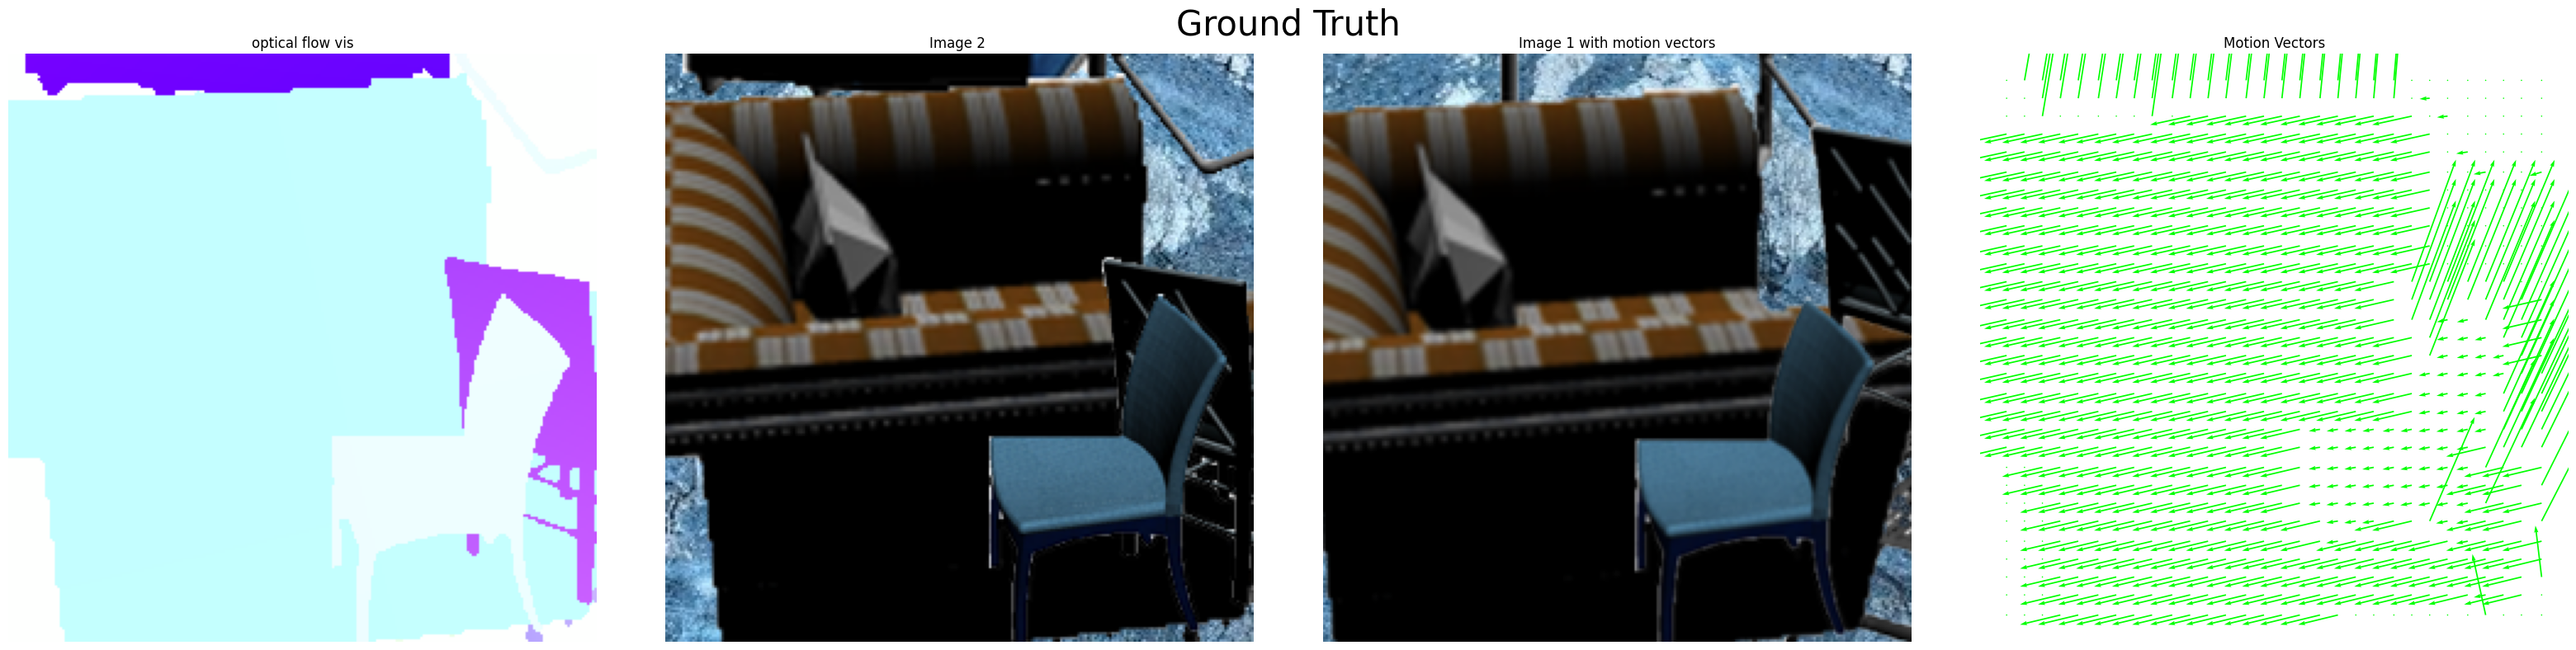

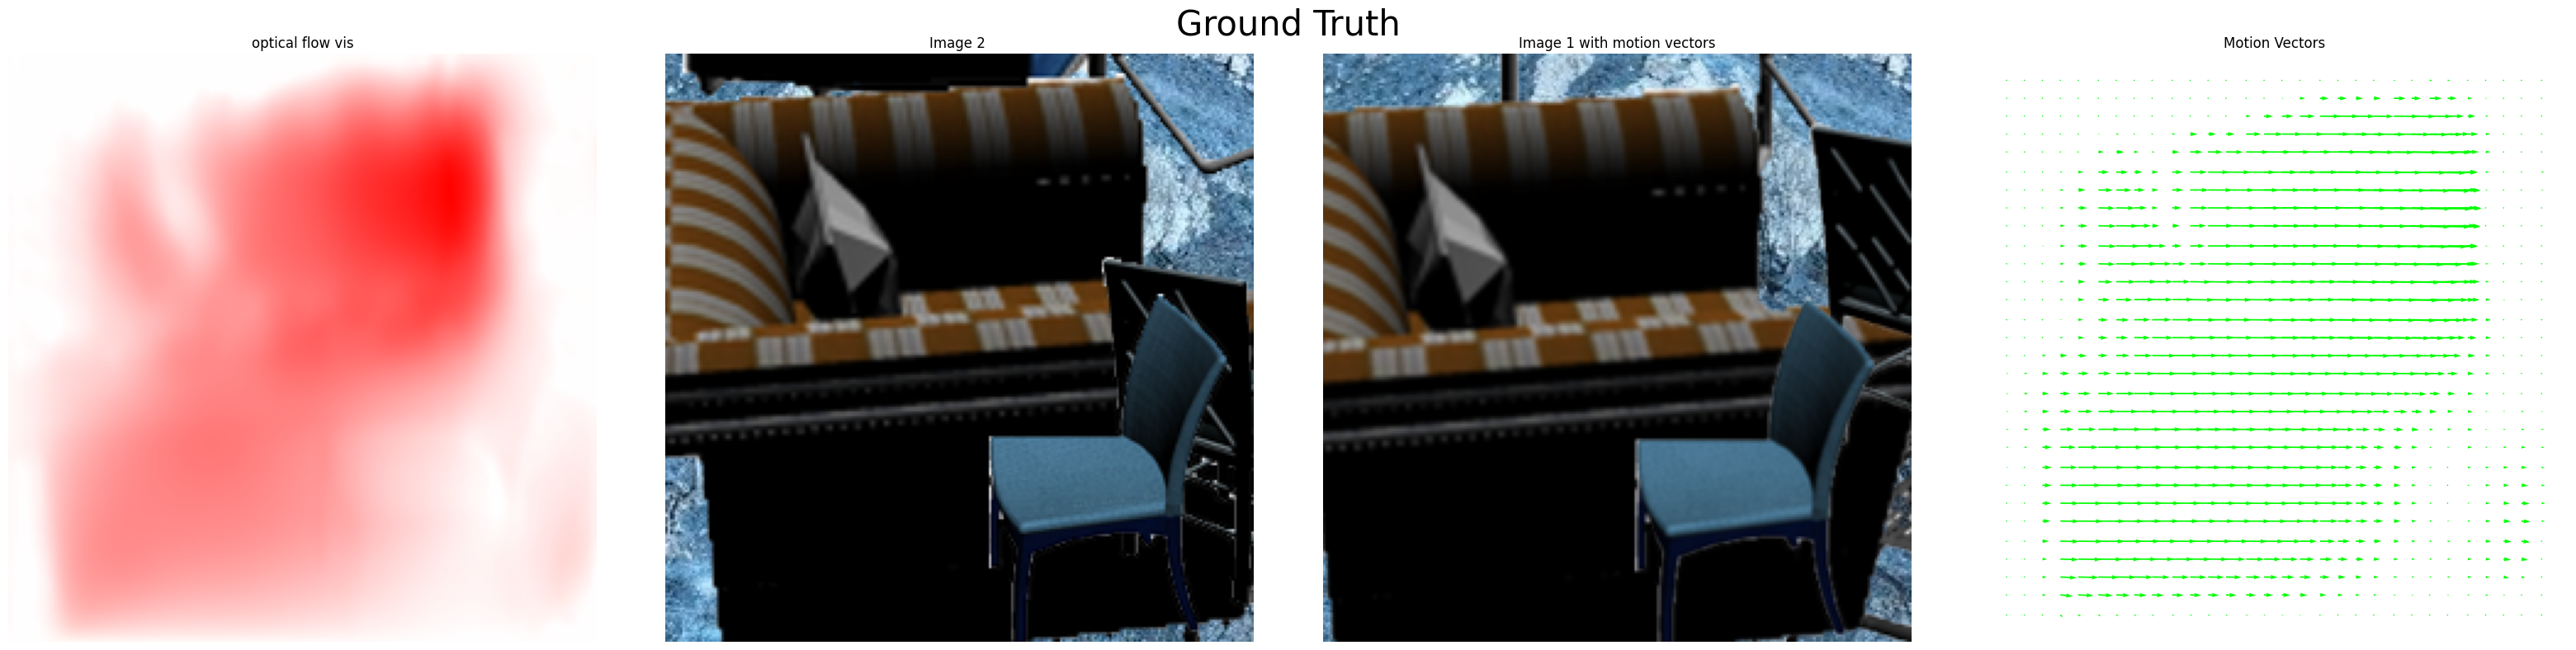

In [12]:
for im_pairs, gt_flow in train_dataset:
    im1 = im_pairs[:, :, :, :3]
    im2 = im_pairs[:, :, :, 3:]
    loss_value, logits = model([im1, im2])
    helpers.plot_ffpmv(im1[0].numpy(), im2[0].numpy(), gt_flow[0].numpy(), clear=True, spacing=8, title="Ground Truth", figsize=(32, 8))
    helpers.plot_ffpmv(im1[0].numpy(), im2[0].numpy(), logits[0].numpy(), clear=False, spacing=8, title="Ground Truth", figsize=(32, 8))

    break    

(16, 240, 240, 2)


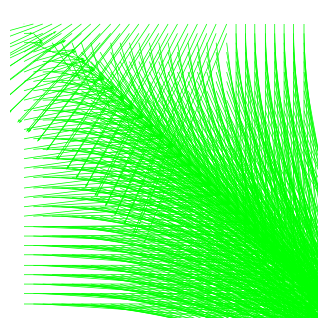

In [68]:
b, w, h, c= gt_flow.shape
x = tf.range(w)
y = tf.range(h)
X, Y = tf.meshgrid(x, y)
X = tf.cast(X, dtype=tf.float32)
Y = tf.cast(Y, dtype=tf.float32)
x_warp = X + gt_flow[:,:,:,0]
y_warp = Y + gt_flow[:,:,:,1]
flow = tf.stack([y_warp, x_warp], axis=-1)
print(flow.shape)
fig, ax = plt.subplots(1, 1, figsize=(8,4))
helpers.plot_quiver(ax, flow[0].numpy() , spacing=8, margin=0, scale=1, color="#00FF00") 


In [73]:
loss_f(flow[0].numpy() ,logits[0].numpy())

<tf.Tensor: shape=(), dtype=float32, numpy=111.937584>

<tf.Tensor: shape=(16, 240, 240, 2), dtype=float32, numpy=
array([[[[2.18971707e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         ...,
         [5.41230179e-02, 3.25741649e-01],
         [5.58975413e-02, 3.13134104e-01],
         [5.67848049e-02, 2.49940053e-01]],

        [[1.80059560e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         ...,
         [5.41169979e-02, 2.09809005e-01],
         [5.58913238e-02, 2.07627580e-01],
         [5.67784905e-02, 2.06536889e-01]],

        [[0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         ...,
         [5.41049615e-02, 1.49468169e-01],
         [5.58788925e-02, 1.46053821e-01],
         [5.67658581e-02, 1.44346640e-01]],

        ...,

        [[1.50310993e-01, 1.27081573e-03],
         [1.13543332e-01, 1.56642101e-03],
         [1.0731053